# Scalable GP Regression (w/ KISS-GP)

## Introduction

For 2-4D functions, SKI (or KISS-GP) can work very well out-of-the-box on larger datasets (100,000+ data points).
Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

One thing to watch out for with multidimensional SKI - you can't use as fine-grain of a grid. If you have a high dimensional problem, you may want to try one of the other scalable regression methods.

This is the same as [the standard KISSGP 1D notebook](../04_Scalable_GP_Regression_1D/KISSGP_Regression_1D.ipynb), but applied to more dimensions.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

### Set up train data

Here we're learning a simple sin function - but in 2 dimensions

In [2]:
# We make an nxn grid of training points spaced every 1/(n-1) on [0,1]x[0,1]
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
# True function is sin( 2*pi*(x0+x1))
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (2 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(0.01)

## The model

As with the 1D case, applying SKI to a multidimensional kernel is as simple as wrapping that kernel with a `GridInterpolationKernel`. You'll want to be sure to set `num_dims` though!

SKI has only one hyperparameter that you need to worry about: the grid size. For 1D functions, a good starting place is to use as many grid points as training points. (Don't worry - the grid points are really cheap to use!). You can use the `gpytorch.utils.grid.choose_grid_size` helper to get a good starting point.

If you want, you can also explicitly determine the grid bounds of the SKI approximation using the `grid_bounds` argument. However, it's easier if you don't use this argument - then GPyTorch automatically chooses the best bounds for you.

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2),
            ), grid_size=grid_size, num_dims=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

## Train the model hyperparameters

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    training_iterations = 30
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

%time train()

Iter 1/30 - Loss: 1.142
Iter 2/30 - Loss: 1.087
Iter 3/30 - Loss: 1.025
Iter 4/30 - Loss: 0.960
Iter 5/30 - Loss: 0.901
Iter 6/30 - Loss: 0.843
Iter 7/30 - Loss: 0.774
Iter 8/30 - Loss: 0.686
Iter 9/30 - Loss: 0.595
Iter 10/30 - Loss: 0.521
Iter 11/30 - Loss: 0.465
Iter 12/30 - Loss: 0.412
Iter 13/30 - Loss: 0.365
Iter 14/30 - Loss: 0.317
Iter 15/30 - Loss: 0.278
Iter 16/30 - Loss: 0.229
Iter 17/30 - Loss: 0.182
Iter 18/30 - Loss: 0.148
Iter 19/30 - Loss: 0.103
Iter 20/30 - Loss: 0.057
Iter 21/30 - Loss: -0.000
Iter 22/30 - Loss: -0.060
Iter 23/30 - Loss: -0.117
Iter 24/30 - Loss: -0.178
Iter 25/30 - Loss: -0.235
Iter 26/30 - Loss: -0.290
Iter 27/30 - Loss: -0.356
Iter 28/30 - Loss: -0.405
Iter 29/30 - Loss: -0.455
Iter 30/30 - Loss: -0.508
CPU times: user 30.4 s, sys: 237 ms, total: 30.7 s
Wall time: 12.1 s


## Make predictions with the model

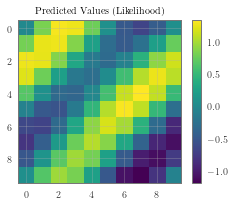

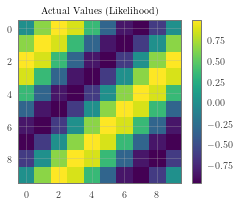

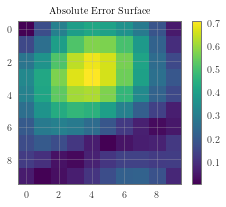

In [5]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
n = 10
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

# Calc abosolute error
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (2 * math.pi))).view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')